In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import scipy
import scipy.io

import seaborn as sns
import matplotlib.pyplot as plt

from rpy2.robjects import r
from rpy2.robjects import pandas2ri

import anndata2ri

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

During startup - Warning message:
Setting LC_CTYPE failed, using "C" 


In [3]:
%%R
suppressPackageStartupMessages({
    library(SingleCellExperiment)
    library(Seurat)
})


    consider that it could be called from a Python process. This
    results in a quasi-obligatory segfault when rpy2 is evaluating
    R code using it. On the hand, rpy2 is accounting for the
    fact that it might already be running embedded in a Python
    process. This is why:
    - Python -> rpy2 -> R -> reticulate: crashes
    - R -> reticulate -> Python -> rpy2: works

    The issue with reticulate is tracked here:
    https://github.com/rstudio/reticulate/issues/208
    

# Expressions

## Load the data

In [4]:
rna = sc.read('../../data/neurips-cite/rna_hvg_batch.h5ad')
rna

AnnData object with n_obs × n_vars = 90261 × 4000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'dataset_id', 'genome', 'hvg', 'log1p', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [5]:
adata_ = ad.AnnData(rna.layers['counts'])
adata_.obs_names = rna.obs_names
adata_.var_names = rna.var_names
adata_.obs['cell_type'] = rna.obs['cell_type']
adata_.obs['batch'] = rna.obs['batch']

In [6]:
%%R -i adata_
rna = as.Seurat(adata_, counts='X', data=NULL)
rna

An object of class Seurat 
4000 features across 90261 samples within 1 assay 
Active assay: originalexp (4000 features, 0 variable features)


# Protein

## Download the data

In [7]:
adt = sc.read('../../data/neurips-cite/protein.h5ad')
adt

AnnData object with n_obs × n_vars = 90261 × 134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [8]:
adata_ = ad.AnnData(adt.layers['counts'])
adata_.obs_names = adt.obs_names
adata_.var_names = adt.var_names
adata_.obs['cell_type'] = adt.obs['cell_type']
adata_.obs['batch'] = adt.obs['batch']

In [9]:
%%R -i adata_
cite = as.Seurat(adata_, counts='X', data=NULL)
cite

An object of class Seurat 
134 features across 90261 samples within 1 assay 
Active assay: originalexp (134 features, 0 variable features)


# Integrate RNA batches

In [10]:
%%R
rna <- RenameAssays(rna, originalexp="RNA")
rna.list <- SplitObject(rna, split.by = "batch")
rna.list <- lapply(X = rna.list, FUN = SCTransform, variable.features.n = 1000)
features <- SelectIntegrationFeatures(object.list = rna.list, nfeatures = 1000)
rna.list <- PrepSCTIntegration(object.list = rna.list, anchor.features = features)

R[write to console]: Renaming default assay from originalexp to RNA

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 4000 by 5227

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 5000 cells



  |======================================================================| 100%


R[write to console]: Found 30 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 4000 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 4000 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 2.53928 mins

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |===================================                                   |  50%
  |                                                                            
  |======================================================================| 100%
R[write to console]: 

R[write to console]: Set default assay to SCT

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 4000 

  |======================================================================| 100%


R[write to console]: Found 31 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 4000 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 4000 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 2.487656 mins

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |===================================                                   |  50%
  |                                                                            
  |======================================================================| 100%
R[write to console]: 

R[write to console]: Set default assay to SCT

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 4000

  |======================================================================| 100%


R[write to console]: Found 33 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 4000 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 4000 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 2.615538 mins

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |===================================                                   |  50%
  |                                                                            
  |======================================================================| 100%
R[write to console]: 

R[write to console]: Set default assay to SCT

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 4000

  |======================================================================| 100%


R[write to console]: Found 69 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 4000 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 4000 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 2.832611 mins

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |===================================                                   |  50%
  |                                                                            
  |======================================================================| 100%
R[write to console]: 

R[write to console]: Set default assay to SCT

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 4000

  |======================================================================| 100%


R[write to console]: Found 35 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 4000 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 4000 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.23091 mins

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |===================================                                   |  50%
  |                                                                            
  |======================================================================| 100%
R[write to console]: 

R[write to console]: Set default assay to SCT

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 3960 

  |======================================================================| 100%


R[write to console]: Found 66 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 3960 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 3960 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.36834 mins

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |===================================                                   |  50%
  |                                                                            
  |======================================================================| 100%
R[write to console]: 

R[write to console]: Set default assay to SCT

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 3777 

  |======================================================================| 100%


R[write to console]: Found 118 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 3777 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 3777 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 2.938391 mins

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |===================================                                   |  50%
  |                                                                            
  |======================================================================| 100%
R[write to console]: 

R[write to console]: Set default assay to SCT

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 4000

  |======================================================================| 100%


R[write to console]: Found 67 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 4000 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 4000 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 2.795597 mins

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |===================================                                   |  50%
  |                                                                            
  |======================================================================| 100%
R[write to console]: 

R[write to console]: Set default assay to SCT

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 4000

  |======================================================================| 100%


R[write to console]: Found 97 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 4000 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 4000 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 2.872276 mins

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |===================================                                   |  50%
  |                                                                            
  |======================================================================| 100%
R[write to console]: 

R[write to console]: Set default assay to SCT

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 3993

  |======================================================================| 100%


R[write to console]: Found 25 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 3993 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 3993 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 2.630195 mins

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |===================================                                   |  50%
  |                                                                            
  |======================================================================| 100%
R[write to console]: 

R[write to console]: Set default assay to SCT

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 3966

  |======================================================================| 100%


R[write to console]: Found 27 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 3966 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 3966 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 58.50602 secs

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |===================================                                   |  50%
  |                                                                            
  |======================================================================| 100%
R[write to console]: 

R[write to console]: Set default assay to SCT

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 3982

  |======================================================================| 100%


R[write to console]: Found 34 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 3982 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 3982 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 2.64846 mins

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |===================================                                   |  50%
  |                                                                            
  |======================================================================| 100%
R[write to console]: 

R[write to console]: Set default assay to SCT



  |                                                  | 0 % ~calculating   |+++++                                             | 8 % ~06s           |+++++++++                                         | 17% ~05s           |+++++++++++++                                     | 25% ~05s           |+++++++++++++++++                                 | 33% ~06s           |+++++++++++++++++++++                             | 42% ~05s           |+++++++++++++++++++++++++                         | 50% ~04s           |++++++++++++++++++++++++++++++                    | 58% ~04s           |++++++++++++++++++++++++++++++++++                | 67% ~03s           |++++++++++++++++++++++++++++++++++++++            | 75% ~03s           |++++++++++++++++++++++++++++++++++++++++++        | 83% ~02s           |++++++++++++++++++++++++++++++++++++++++++++++    | 92% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=09s  


In [12]:
%%R
anchors <- FindIntegrationAnchors(object.list = rna.list, normalization.method = "SCT", 
    anchor.features = features)

R[write to console]: Finding all pairwise anchors



  |                                                  | 0 % ~calculating  

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 10307 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 9414 anchors



  |+                                                 | 2 % ~53m 06s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 13099 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 11778 anchors



  |++                                                | 3 % ~55m 10s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 10812 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 9403 anchors



  |+++                                               | 5 % ~52m 01s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 14572 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 11375 anchors



  |++++                                              | 6 % ~54m 10s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 12357 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 9213 anchors



  |++++                                              | 8 % ~52m 54s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 13158 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 10129 anchors



  |+++++                                             | 9 % ~52m 19s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 11163 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 9926 anchors



  |++++++                                            | 11% ~49m 22s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 9206 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 7957 anchors



  |+++++++                                           | 12% ~46m 32s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 10105 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 8981 anchors



  |+++++++                                           | 14% ~45m 12s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 15473 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 14044 anchors



  |++++++++                                          | 15% ~47m 29s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 10174 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 7621 anchors



  |+++++++++                                         | 17% ~45m 33s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 13043 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 10023 anchors



  |++++++++++                                        | 18% ~44m 03s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 10661 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 7907 anchors



  |++++++++++                                        | 20% ~42m 56s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 16461 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 12407 anchors



  |+++++++++++                                       | 21% ~45m 36s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 10099 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 7785 anchors



  |++++++++++++                                      | 23% ~44m 23s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 13033 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 9768 anchors



  |+++++++++++++                                     | 24% ~43m 27s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 11282 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 7948 anchors



  |+++++++++++++                                     | 26% ~42m 12s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 12388 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 9221 anchors



  |++++++++++++++                                    | 27% ~41m 31s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 22485 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 16811 anchors



  |+++++++++++++++                                   | 29% ~44m 04s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 15331 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 11966 anchors



  |++++++++++++++++                                  | 30% ~43m 15s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 15969 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 10560 anchors



  |++++++++++++++++                                  | 32% ~43m 40s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 12048 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 9167 anchors



  |+++++++++++++++++                                 | 33% ~42m 19s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 12969 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 10233 anchors



  |++++++++++++++++++                                | 35% ~41m 12s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 11873 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 9312 anchors



  |+++++++++++++++++++                               | 36% ~40m 17s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 21677 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 17342 anchors



  |+++++++++++++++++++                               | 38% ~41m 27s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 15473 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 12483 anchors



  |++++++++++++++++++++                              | 39% ~40m 29s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 17742 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 12507 anchors



  |+++++++++++++++++++++                             | 41% ~40m 37s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 20630 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 15749 anchors



  |++++++++++++++++++++++                            | 42% ~40m 40s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 10320 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 7550 anchors



  |++++++++++++++++++++++                            | 44% ~39m 10s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 11070 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 7921 anchors



  |+++++++++++++++++++++++                           | 45% ~37m 47s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 9571 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 7182 anchors



  |++++++++++++++++++++++++                          | 47% ~36m 28s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 19964 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 14684 anchors



  |+++++++++++++++++++++++++                         | 48% ~36m 31s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 13676 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 10447 anchors



  |+++++++++++++++++++++++++                         | 50% ~35m 24s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 17265 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 11456 anchors



  |++++++++++++++++++++++++++                        | 52% ~34m 54s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 20024 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 14170 anchors



  |+++++++++++++++++++++++++++                       | 53% ~34m 37s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 22105 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 17593 anchors



  |++++++++++++++++++++++++++++                      | 55% ~34m 30s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 11184 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 10098 anchors



  |+++++++++++++++++++++++++++++                     | 56% ~32m 59s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 11438 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 10315 anchors



  |+++++++++++++++++++++++++++++                     | 58% ~31m 31s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 11548 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 9918 anchors



  |++++++++++++++++++++++++++++++                    | 59% ~30m 10s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 14818 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 12801 anchors



  |+++++++++++++++++++++++++++++++                   | 61% ~29m 21s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 10928 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 9942 anchors



  |++++++++++++++++++++++++++++++++                  | 62% ~27m 59s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 12260 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 10501 anchors



  |++++++++++++++++++++++++++++++++                  | 64% ~26m 52s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 12900 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 11088 anchors



  |+++++++++++++++++++++++++++++++++                 | 65% ~25m 50s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 14855 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 13277 anchors



  |++++++++++++++++++++++++++++++++++                | 67% ~24m 55s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 12286 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 10685 anchors



  |+++++++++++++++++++++++++++++++++++               | 68% ~23m 57s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 8139 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 7542 anchors



  |+++++++++++++++++++++++++++++++++++               | 70% ~22m 33s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 8904 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 8333 anchors



  |++++++++++++++++++++++++++++++++++++              | 71% ~21m 11s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 8773 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 8003 anchors



  |+++++++++++++++++++++++++++++++++++++             | 73% ~19m 53s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 9924 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 8912 anchors



  |++++++++++++++++++++++++++++++++++++++            | 74% ~18m 46s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 8350 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 7812 anchors



  |++++++++++++++++++++++++++++++++++++++            | 76% ~17m 29s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 9171 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 8181 anchors



  |+++++++++++++++++++++++++++++++++++++++           | 77% ~16m 19s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 8893 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 7753 anchors



  |++++++++++++++++++++++++++++++++++++++++          | 79% ~15m 11s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 11288 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 10281 anchors



  |+++++++++++++++++++++++++++++++++++++++++         | 80% ~14m 10s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 9869 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 8850 anchors



  |+++++++++++++++++++++++++++++++++++++++++         | 82% ~13m 05s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 9865 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 9135 anchors



  |++++++++++++++++++++++++++++++++++++++++++        | 83% ~11m 54s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 10781 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 9228 anchors



  |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~10m 46s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 10893 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 9645 anchors



  |++++++++++++++++++++++++++++++++++++++++++++      | 86% ~09m 38s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 12116 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 10476 anchors



  |++++++++++++++++++++++++++++++++++++++++++++      | 88% ~08m 33s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 13317 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 8877 anchors



  |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~06m 24s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 11634 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 9544 anchors



  |+++++++++++++++++++++++++++++++++++++++++++++++   | 92% ~05m 21s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 11373 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 9237 anchors



  |+++++++++++++++++++++++++++++++++++++++++++++++   | 94% ~04m 17s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 14307 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 12526 anchors



  |++++++++++++++++++++++++++++++++++++++++++++++++  | 95% ~03m 14s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 11622 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 9750 anchors



  |+++++++++++++++++++++++++++++++++++++++++++++++++ | 97% ~02m 10s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 13272 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 11616 anchors



  |++++++++++++++++++++++++++++++++++++++++++++++++++| 98% ~01m 05s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 11002 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 9574 anchors



  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01h 10m 60s


In [13]:
%%R
integrated <- IntegrateData(anchorset = anchors, normalization.method = "SCT")

R[write to console]: Merging dataset 11 into 8

R[write to console]: Extracting anchors for merged samples

R[write to console]: Finding integration vectors

R[write to console]: Finding integration vector weights

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to co

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[writ

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: |

R[write to

In [14]:
%%R
integrated <- RunPCA(integrated)

R[write to console]: PC_ 1 
Positive:  S100A9, S100A8, LYZ, S100A12, VCAN, CTSS, FCN1, AC020656.1, MNDA, FGL2 
	   CD14, CST3, IFI30, LST1, CYBB, TYROBP, MS4A6A, RGS2, TYMP, AIF1 
	   LGALS1, FOS, FTL, FCER1G, GRN, COTL1, CSTA, PSAP, NAMPT, SERPINA1 
Negative:  HBB, HBD, AHSP, HBM, HBA2, CA1, PRDX2, CA2, HIST1H4C, HEMGN 
	   HBA1, HIST1H1B, GYPB, SLC4A1, GYPA, NUSAP1, CENPF, BLVRB, PCLAF, SLC25A37 
	   TFRC, TOP2A, MYL4, ALAS2, HIST1H3B, PTTG1, SMIM1, HMBS, SNCA, TUBB 
PC_ 2 
Positive:  NKG7, GNLY, CCL5, GZMA, KLRB1, IL32, CST7, GZMB, PRF1, GZMH 
	   GZMM, CCL4, FGFBP2, KLRD1, CD3D, CTSW, CLIC3, CD247, SPON2, KLRF1 
	   TRBC1, CD7, SAMD3, XCL2, TRDC, HOPX, ETS1, KLRK1, CD3G, GZMK 
Negative:  S100A9, S100A8, LYZ, S100A12, HBB, VCAN, AC020656.1, FCN1, CTSS, MNDA 
	   HBD, CST3, AHSP, FGL2, CA1, CD14, HBM, IFI30, LST1, FTL 
	   AIF1, CYBB, MS4A6A, HBA2, RGS2, PRDX2, FOS, RETN, GRN, CSTA 
PC_ 3 
Positive:  IGHM, STMN1, IGLL1, CD79B, TCL1A, PPP1R14B, VPREB3, MZB1, TCF4, FABP5 
	   IGKC, SOX

# Integrate ADT batches

In [16]:
%%R
cite <- RenameAssays(cite, originalexp='ADT')

cite.list <- SplitObject(cite, split.by = "batch")

cite.list <- lapply(X = cite.list, FUN = function(x) {
    VariableFeatures(x) <- rownames(x[["ADT"]])
    x <- NormalizeData(x, normalization.method = 'CLR', margin = 2, verbose=FALSE)
})

features <- SelectIntegrationFeatures(object.list = cite.list)

cite.list <- lapply(X = cite.list, FUN = function(x) {
    x <- ScaleData(x, features = features, verbose=FALSE)
    x <- RunPCA(x, features = features, reduction.name = "pca", verbose=FALSE)
})

anchors <- FindIntegrationAnchors(object.list = cite.list, reduction = "rpca", 
    dims = 1:30, verbose=FALSE)
integrated_adt <- IntegrateData(anchorset = anchors, dims = 1:30)

integrated_adt <- ScaleData(integrated_adt, verbose=FALSE)
integrated_adt <- RunPCA(integrated_adt, reduction.name = "apca", verbose=FALSE)

R[write to console]: Renaming default assay from originalexp to ADT



  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~03m 17s       |++                                                | 3 % ~03m 25s       |+++                                               | 5 % ~03m 23s       |++++                                              | 6 % ~03m 39s       |++++                                              | 8 % ~03m 45s       |+++++                                             | 9 % ~03m 51s       |++++++                                            | 11% ~03m 42s       |+++++++                                           | 12% ~03m 33s       |+++++++                                           | 14% ~03m 28s       |++++++++                                          | 15% ~03m 30s       |+++++++++                                         | 17% ~03m 28s       |++++++++++                                        | 18% ~03m 25s       |++++++++++                                        | 20% ~03m 

R[write to console]: Merging dataset 1 into 3

R[write to console]: Extracting anchors for merged samples

R[write to console]: Finding integration vectors

R[write to console]: Finding integration vector weights

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to con

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[writ

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: |

R[write to

# Run Seurat v4 WNN
Following https://satijalab.org/seurat/v4.0/weighted_nearest_neighbor_analysis.html.

In [17]:
%%R
integrated[["IADT"]] <- integrated_adt[["integrated"]]
integrated[["apca"]] <- integrated_adt[["apca"]]

integrated <- FindMultiModalNeighbors(integrated, reduction.list = list("pca", "apca"), 
                              dims.list = list(1:50, 1:30), modality.weight.name = "RNA.weight")

integrated <- RunSPCA(integrated, assay = 'integrated', graph = 'wsnn', npcs = 20)

R[write to console]: Calculating cell-specific modality weights

R[write to console]: Finding 20 nearest neighbors for each modality.



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~25s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=49s  


R[write to console]: Calculating kernel bandwidths



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~05s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=10s  


R[write to console]: Finding multimodal neighbors



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~01m 27s       |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=02m 59s
  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~09s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=13s  


R[write to console]: Constructing multimodal KNN graph

R[write to console]: Constructing multimodal SNN graph

R[write to console]: Computing sPCA transformation



In [18]:
%%R -o spca
spca = Embeddings(object = integrated[["spca"]])

In [20]:
adata = sc.AnnData(spca)
adata.obs = adata_.obs
adata

AnnData object with n_obs × n_vars = 90261 × 20
    obs: 'cell_type', 'batch'

In [21]:
%%R -o wnn
wnn <- as.data.frame(summary(integrated@graphs$wknn))

In [22]:
wnn['i'] = wnn['i'] - 1
wnn['j'] = wnn['j'] - 1

In [23]:
adata.obsp['wnn_connectivities'] = scipy.sparse.coo_matrix((wnn['x'], (wnn['i'], wnn['j'])))
adata.obsp['wnn_connectivities'] = scipy.sparse.csr_matrix(adata.obsp['wnn_connectivities'])

In [24]:
adata.write('neurips-cite-seurat.h5ad')

# Visualize results

In [26]:
sc.pp.neighbors(adata)
adata.obsp['connectivities'] = adata.obsp['wnn_connectivities'].copy()
# delete distances to make sure we are not using anything calculated with sc.pp.neighbors()
del adata.obsp['distances']
sc.tl.umap(adata)

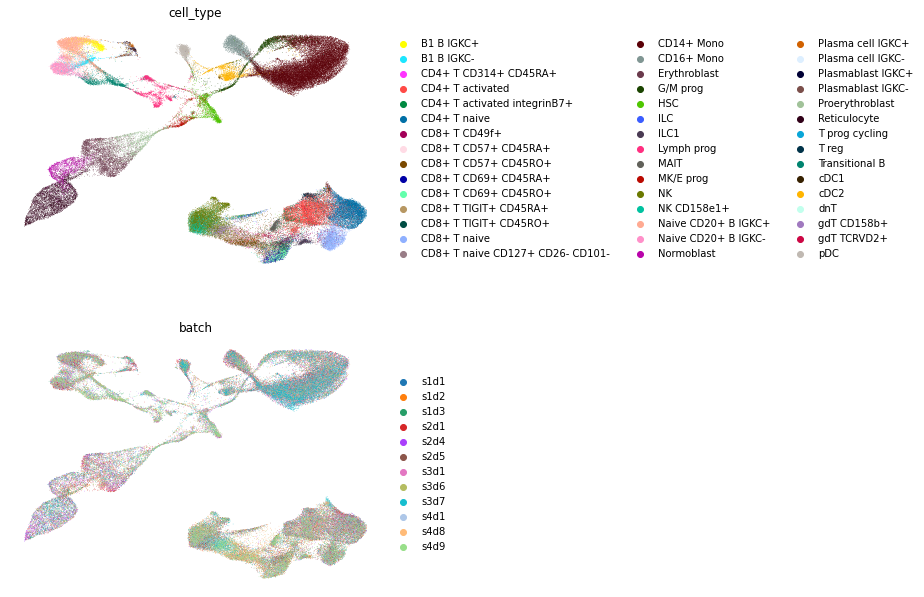

In [27]:
sc.pl.umap(adata, color=['cell_type', 'batch'], ncols=1, frameon=False, save='neurips-cite-seurat.png')

In [25]:
%%R
sessionInfo()

R version 4.1.3 (2022-03-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/bridge/lib/libopenblasp-r0.3.20.so

locale:
 [1] LC_CTYPE=C                 LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    tools     stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] Matrix_1.4-1                sp_1.5-0                   
 [3] SeuratObject_4.1.0          Seurat_4.1.1.9001          
 [5] SingleCellExperiment_1.16.0 SummarizedExperiment_1.24.0
 [7] Biobase_2.54.0              GenomicRanges_1.46.1 